In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf

# Import Zheng's modules
import reinforcement_learning as rl
import simulation as sm

# 1. Setup radiation detection simulation environment

In [3]:
# Parameters for the testing environment
global WORLD_SIZE 
WORLD_SIZE = rl.WORLD_SIZE
buildings = [set((4, WORLD_SIZE+1-i) for i in range(1,9))]
current_position = [1,10]
source_position = [8.2,8.2]
maximum_steps = 100
VALID_ACTIONS = [0,1,2,3]
# Initialize the testing environment
test_env = sm.RadEnv2D_New(WORLD_SIZE,WORLD_SIZE)

# 2. Load trained reinforcement learning model

In [4]:
# Initialize tensorflow
tf.reset_default_graph()
sess = tf.InteractiveSession()
# Load CNN model
q_estimator = rl.Estimator_CNN(scope="q_estimator")
policy = rl.make_epsilon_greedy_policy(
    q_estimator,
    len(VALID_ACTIONS))
checkpoint_path = './experiments/DCQN_23/checkpoints/model842500'
saver = tf.train.Saver()
saver.restore(sess, checkpoint_path)

Instructions for updating:
Please switch to tf.train.get_global_step


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:96: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


INFO:tensorflow:Restoring parameters from ./experiments/DCQN_23/checkpoints/model842500


# 3. Perform a radiation source detection task

In [5]:
test_state = test_env.resetCNN(buildings, current_position, source_position)
sx, sy = test_env.source_x, test_env.source_y
test_total_reward = 0
test_steps = 0
mns = []
rms = []
maps = []
mns.append(test_env.measurement_number.copy())
rms.append(test_env.radiation_mean.copy())
maps.append(test_env.map.copy())

while test_steps <= maximum_steps:
    # Take a step according to RL policy
    test_action_probs = policy(sess, test_state, 0.05)
    test_action = np.random.choice(np.arange(len(test_action_probs)), p=test_action_probs)
    test_next_state, test_reward, test_done= test_env.stepCNN(VALID_ACTIONS[test_action])
    test_total_reward = test_total_reward + test_reward
    mns.append(test_env.measurement_number.copy())
    rms.append(test_env.radiation_mean.copy())
    maps.append(test_env.map.copy())
    if test_done:
        break
    else:
        test_state = test_next_state
        test_steps = test_steps + 1

print('The final reward is ', test_total_reward)

The final reward is  6.0


# 4. Drawing results

### 4.1 Static drawing of final searching path

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


Text(0.5,1,'Searching path')

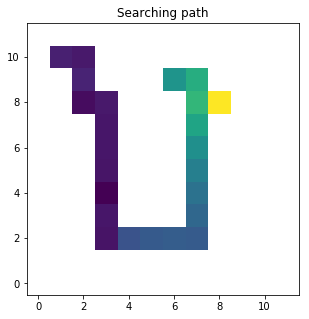

In [6]:
sx, sy = test_env.source_x, test_env.source_y
fig, ax = plt.subplots(1,1, figsize=(5,5))

state2 = np.log(rms[-1].copy())
im2 = ax.imshow(state2.T, origin='lower left', animated=True)
ax.set_title('Searching path')

### 4.2 Animation of searching progress
( May need to install additional packages)

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log


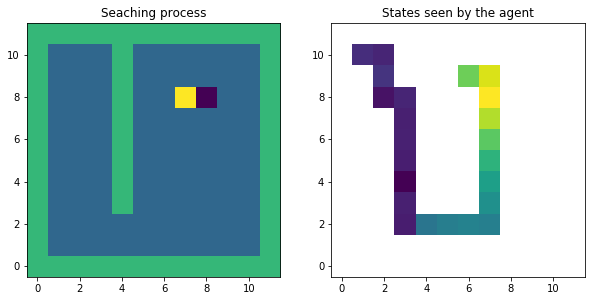

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

sx, sy = test_env.source_x, test_env.source_y

fig, ax = plt.subplots(1,2, figsize=(10,5))
ims = []

for i in range(len(maps)-1):
    state1 = maps[i].copy()
    state1[int(sx),int(sy)] = -1
    im1 = ax[0].imshow(state1.T, origin='lower left', animated=True)
    ax[0].set_title('Seaching process')
    
    state2 = np.log(rms[i].copy())
    im2 = ax[1].imshow(state2.T, origin='lower left', animated=True)
    ax[1].set_title('States seen by the agent')
    
    ims.append([im1, im2])

ani = animation.ArtistAnimation(fig, ims, interval=200, blit=True,
                                repeat_delay=1000)

HTML(ani.to_jshtml())